In [1]:
#LSST z-pred for realistic sims run with SALT3 on NERSC ugrizY

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import astropy
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import matplotlib
import glob

import time
import sys
import os
import pandas as pd

import astropy.units as u
from astropy.coordinates import Angle, SkyCoord, AltAz, EarthLocation
from astropy.time import Time
from astropy.coordinates import Angle

from scipy import interpolate

import galsim
from scipy import ndimage
import scipy

from scipy.stats import chi2
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# location of CTIO
earth_location = EarthLocation.of_site('La Silla Observatory')

print(earth_location)

(1838554.9580025, -5258914.42492168, -3099898.78073271) m


In [3]:
galsim.version, np.__version__, astropy.__version__, scipy.__version__, pd.__version__

('2.3.4', '1.21.6', '4.3.1', '1.7.3', '1.3.5')

In [4]:
ref_star_SED = np.loadtxt('/global/cfs/cdirs/des/jlee/SN_Ia/star_SEDs/ukk5v.dat')

f_source = interp1d(ref_star_SED.transpose()[0], ref_star_SED.transpose()[1])

LSST_bands = ['u', 'g', 'r', 'i', 'z', 'Y']
band_colors = ['blue', 'green', 'red', 'orange', 'violet']

SNANA_lsst_bands = []
for i in range(len(LSST_bands[:-1])):
    SNANA_lsst_bands.append(np.loadtxt('DCR_AstroZ/filter_functions/LSST_baseline_1.9/LSST_' + LSST_bands[i] + '.dat', skiprows = 7))


In [5]:
def find_nearest(array, values):
    array = np.asarray(array)
    idxs = np.zeros(len(values))
    for i in range(len(values)):
        idxs[i] = (np.abs(array - values[i])).argmin()
    idxs = idxs.astype(int)
    return idxs, array[idxs]

In [6]:
dir_str = 'JASON_DCR_ASTROZ_COADD_REALISTIC_v1113/'
SIM_dir_str = '/pscratch/sd/a/astjason/DCR_AstroZ/' + dir_str
t_head = Table.read(glob.glob(SIM_dir_str + '*HEAD.FITS*')[0])
t_phot = Table.read(glob.glob(SIM_dir_str + '*PHOT.FITS*')[0])
t_DCR = pd.read_csv(glob.glob(SIM_dir_str + '*.DCR*')[0], delim_whitespace=True, skiprows = 6)
t_DUMP = pd.read_csv(glob.glob(SIM_dir_str + '*.DUMP*')[0], delim_whitespace=True, skiprows = 5)

In [7]:
AM_range = np.arange(1.00, 3.00, 0.01)
z_range = np.arange(0.00, 1.21, 0.01)

In [8]:
no_obs_all = np.loadtxt('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_no_obs_all.txt')
SNRs_all = np.load('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_SNRs_all.npy', allow_pickle=True)
AMs_all = np.load('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_AMs_all.npy', allow_pickle=True)

In [9]:
where_epoch_condition, where_epoch_and_SNR, where_epoch_and_SNR_and_AM = np.load('DCR_AstroZ/' + dir_str + 'where_conditions.npy', allow_pickle=True)

In [13]:
lcfit_CIDs = np.loadtxt(SIM_dir_str + 'lcfit_CIDs_v240111.txt')
tobs_lcfit = np.loadtxt(SIM_dir_str + 'lcfit_TOBS_v240111.txt')


In [14]:
lcfit_CIDs.shape, np.intersect1d(lcfit_CIDs, where_epoch_and_SNR).shape, where_epoch_and_SNR.shape

((14170,), (7864,), (8622,))

In [15]:
def find_elements_not_in_array(arr1, arr2):
    return [element for element in arr1 if element not in arr2]

elements_not_in_array2 = find_elements_not_in_array(np.arange(20000), lcfit_CIDs.astype(int))

(array([0.        , 0.        , 0.        , 0.1893162 , 0.13768245,
        0.10156712, 0.07966026, 0.06357317, 0.05191667, 0.0435421 ,
        0.0372244 , 0.03135088, 0.02690613, 0.02285748, 0.01976795,
        0.0174423 , 0.01528925, 0.0138718 , 0.01198469, 0.01129435,
        0.01014285, 0.00931954, 0.00806901, 0.00744092, 0.00718346,
        0.00636298, 0.00598669, 0.00558776, 0.00508699, 0.00488328,
        0.00465411, 0.00434855, 0.0041109 , 0.00381665, 0.00362144,
        0.00342056, 0.0031829 , 0.00304144, 0.00278398, 0.00266798,
        0.00249257, 0.00234545, 0.00224359, 0.00222662, 0.00204272,
        0.00207667, 0.00202008, 0.00178808, 0.00180506]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <BarContainer object of 49 artists>)

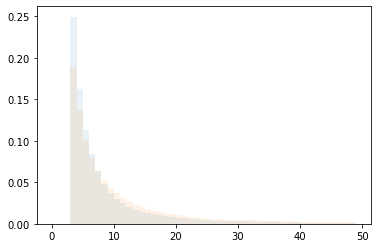

In [16]:
plt.hist(np.concatenate(np.concatenate(SNRs_all[np.array(elements_not_in_array2)])), np.arange(0, 50), alpha = 0.1, density = True)
plt.hist(np.concatenate(np.concatenate(SNRs_all[lcfit_CIDs.astype(int)])), np.arange(0, 50), alpha = 0.1, density = True)

In [17]:
max_SNRs = np.zeros(len(elements_not_in_array2))
for i in range(len(elements_not_in_array2)):
    max_SNRs[i] = np.max(np.concatenate(SNRs_all[np.array(elements_not_in_array2)][i]))

In [18]:
max_SNRs_lcfit = np.zeros(len(lcfit_CIDs.astype(int)))
for i in range(len(lcfit_CIDs.astype(int))):
    max_SNRs_lcfit[i] = np.max(np.concatenate(SNRs_all[np.array(lcfit_CIDs.astype(int))][i]))

(array([0.        , 0.        , 0.        , 0.        , 0.02935118,
        0.04814624, 0.0576725 , 0.05981806, 0.0599897 , 0.05750086,
        0.05475455, 0.05097837, 0.0472022 , 0.04085136, 0.03741847,
        0.03544456, 0.03364229, 0.03123927, 0.02789221, 0.0266907 ,
        0.02257123, 0.02162719, 0.01776519, 0.01767937, 0.01639204,
        0.01613457, 0.01373155, 0.01364573, 0.01115688, 0.01313079,
        0.01253004, 0.01012702, 0.01029866, 0.00909715, 0.00978373,
        0.00875386, 0.00780982, 0.00729488, 0.00523515, 0.00652249,
        0.00600755, 0.00557844, 0.00592173, 0.00592173, 0.00557844,
        0.00514933, 0.0054068 , 0.00600755, 0.00454858]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <BarContainer object of 49 artists>)

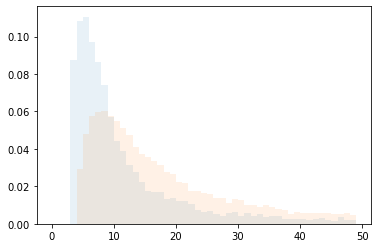

In [19]:
plt.hist(max_SNRs, np.arange(0, 50), alpha = 0.1, density = True)
plt.hist(max_SNRs_lcfit, np.arange(0, 50), alpha = 0.1, density = True)

(array([0.        , 0.        , 0.        , 0.1893162 , 0.13768245,
        0.10156712, 0.07966026, 0.06357317, 0.05191667, 0.0435421 ,
        0.0372244 , 0.03135088, 0.02690613, 0.02285748, 0.01976795,
        0.0174423 , 0.01528925, 0.0138718 , 0.01198469, 0.01129435,
        0.01014285, 0.00931954, 0.00806901, 0.00744092, 0.00718346,
        0.00636298, 0.00598669, 0.00558776, 0.00508699, 0.00488328,
        0.00465411, 0.00434855, 0.0041109 , 0.00381665, 0.00362144,
        0.00342056, 0.0031829 , 0.00304144, 0.00278398, 0.00266798,
        0.00249257, 0.00234545, 0.00224359, 0.00222662, 0.00204272,
        0.00207667, 0.00202008, 0.00178808, 0.00180506]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <BarContainer object of 49 artists>)

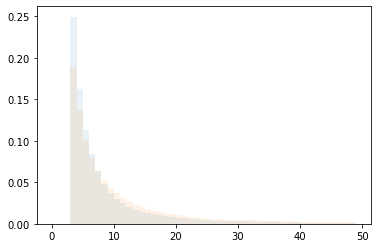

In [20]:
plt.hist(np.concatenate(np.concatenate(SNRs_all[np.array(elements_not_in_array2)])), np.arange(0, 50), alpha = 0.1, density = True)
plt.hist(np.concatenate(np.concatenate(SNRs_all[lcfit_CIDs.astype(int)])), np.arange(0, 50), alpha = 0.1, density = True)

In [21]:
tobs_types = ['fmax_clump_tobs', 'combined_with_lcfit_tobs', 'ideal_tobs']

z_preds_wrt_zY = np.load('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_preds_wrt_zY.npy' %tobs_types[0]), np.load('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_pdfs_wrt_zY.npy' %tobs_types[0]), np.load('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_quantiles_wrt_zY.npy' %tobs_types[0])
a, b, c, d = z_preds_wrt_zY[0][0], z_preds_wrt_zY[0][1], z_preds_wrt_zY[1], z_preds_wrt_zY[2]
z_preds_wrt_zY = a, b, c, d

z_preds_wrt_zY_combined_with_lcfit_tobs = np.load('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_preds_wrt_zY.npy' %tobs_types[1]), np.load('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_pdfs_wrt_zY.npy' %tobs_types[1]), np.load('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_quantiles_wrt_zY.npy' %tobs_types[1])
a, b, c, d = z_preds_wrt_zY_combined_with_lcfit_tobs[0][0], z_preds_wrt_zY_combined_with_lcfit_tobs[0][1], z_preds_wrt_zY_combined_with_lcfit_tobs[1], z_preds_wrt_zY_combined_with_lcfit_tobs[2]
z_preds_wrt_zY_combined_with_lcfit_tobs = a, b, c, d

z_preds_wrt_zY_ideal_tobs = np.load('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_preds_wrt_zY.npy' %tobs_types[2]), np.load('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_pdfs_wrt_zY.npy' %tobs_types[2]), np.load('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_quantiles_wrt_zY.npy' %tobs_types[2])
a, b, c, d = z_preds_wrt_zY_ideal_tobs[0][0], z_preds_wrt_zY_ideal_tobs[0][1], z_preds_wrt_zY_ideal_tobs[1], z_preds_wrt_zY_ideal_tobs[2]
z_preds_wrt_zY_ideal_tobs = a, b, c, d

In [22]:
def z_pred_photoz(host_photo_z, z_range, sig = 0.34135, zmin = 0.00, zmax = 1.2001, zprecision = 1e-4):
    z_interp = np.arange(zmin, zmax, zprecision)
    z_pred_CDF50, z_pred_peaks = np.zeros([len(host_photo_z), 3]), np.zeros([len(host_photo_z), 3]) #value, +- 1sigma
    for h in range(len(host_photo_z)):
        if host_photo_z[h].mean() == 0:
            host_photo_z[h] = np.ones(len(z_range))
        max_ind = np.argmax(host_photo_z[h])
        max_ind_z_interp = np.where(np.round(z_interp, 5) == np.round(z_range[max_ind], 2))[0]
        cdf = interp1d(z_range, np.cumsum(host_photo_z[h])/np.sum(host_photo_z[h]), fill_value='extrapolate')
        z_pred_CDF50[h] = z_interp[find_nearest(cdf(z_interp), [0.5, 0.5 - sig, 0.5 + sig])[0]]
        z_pred_peaks[h] = z_interp[find_nearest(cdf(z_interp), [cdf(z_interp[max_ind_z_interp]), cdf(z_interp[max_ind_z_interp]) - sig, cdf(z_interp[max_ind_z_interp]) + sig])[0]]
    return z_pred_CDF50, z_pred_peaks, host_photo_z

In [23]:
for i in range(20000):
    if np.isnan(z_preds_wrt_zY_combined_with_lcfit_tobs[2])[i].mean() != 0.0:
        print(i)

In [24]:
def combine_pdfs(astro_z, host_photo_z, z_range, sig = 0.34135, zmin = 0.00, zmax = 1.2001, zprecision = 1e-4, no_quantiles = 11):
    z_interp = np.arange(zmin, zmax, zprecision)
    z_pred_CDF50, z_pred_peaks = np.zeros([len(astro_z), 3]), np.zeros([len(astro_z), 3]) #value, +- 1sigma
    total_post, z_quantiles = np.zeros([len(astro_z), len(z_range)]), np.zeros([len(astro_z), no_quantiles])
    for h in range(len(astro_z)):
        if astro_z[h].mean() == 0:
            astro_z[h] = np.ones(len(z_range))
        if host_photo_z[h].mean() == 0:
            host_photo_z[h] = np.ones(len(z_range))
        total_post[h] = astro_z[h] * host_photo_z[h]
        max_ind = np.argmax(total_post[h])
        max_ind_z_interp = np.where(np.round(z_interp, 5) == np.round(z_range[max_ind], 2))[0]
        cdf = interp1d(z_range, np.cumsum(total_post[h])/np.sum(total_post[h]), fill_value='extrapolate')
        z_pred_CDF50[h] = z_interp[find_nearest(cdf(z_interp), [0.5, 0.5 - sig, 0.5 + sig])[0]]
        z_pred_peaks[h] = z_interp[find_nearest(cdf(z_interp), [cdf(z_interp[max_ind_z_interp]), cdf(z_interp[max_ind_z_interp]) - sig, cdf(z_interp[max_ind_z_interp]) + sig])[0]]
        z_quantiles[h] = z_interp[find_nearest(cdf(z_interp), np.linspace(0, 1, num = no_quantiles))[0]]
    return z_pred_CDF50, z_pred_peaks, total_post, z_quantiles

In [25]:
gal_photoz_pdfs = np.loadtxt(SIM_dir_str + dir_str[:-1] + '_gal_photoz_pdfs.txt')
z_preds_photo_z = z_pred_photoz(gal_photoz_pdfs, z_range)

In [26]:
z_preds_with_host_photo_z = combine_pdfs(z_preds_wrt_zY_combined_with_lcfit_tobs[2], gal_photoz_pdfs, z_range)
where_astro_host_z_zero = np.where(z_preds_with_host_photo_z[3].transpose()[-1] == 0.0)[0]
z_preds_with_host_photo_z[3][where_astro_host_z_zero] = np.linspace(0, 1.2, num = 11)

/global/homes/a/astjason/.conda/envs/SN_Ia/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [27]:
#Do test with narrow Gaussian

In [28]:
def within_precision(z_true_values, z_pred_values, precision):
    where_precision = np.where(np.isclose(z_true_vals, z_pred_vals, atol = precision) == True)[0]
    return len(where_precision)/len(z_true_values)

def outlier_rates(z_true_values, z_pred_values, precision):
    where_outlier = np.where(abs((z_pred_values - z_true_values)/(1 + z_true_values)) > precision)[0]
    return len(where_outlier)/len(z_true_values)

In [29]:
z_true = t_head['REDSHIFT_FINAL']

In [30]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'style'  : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

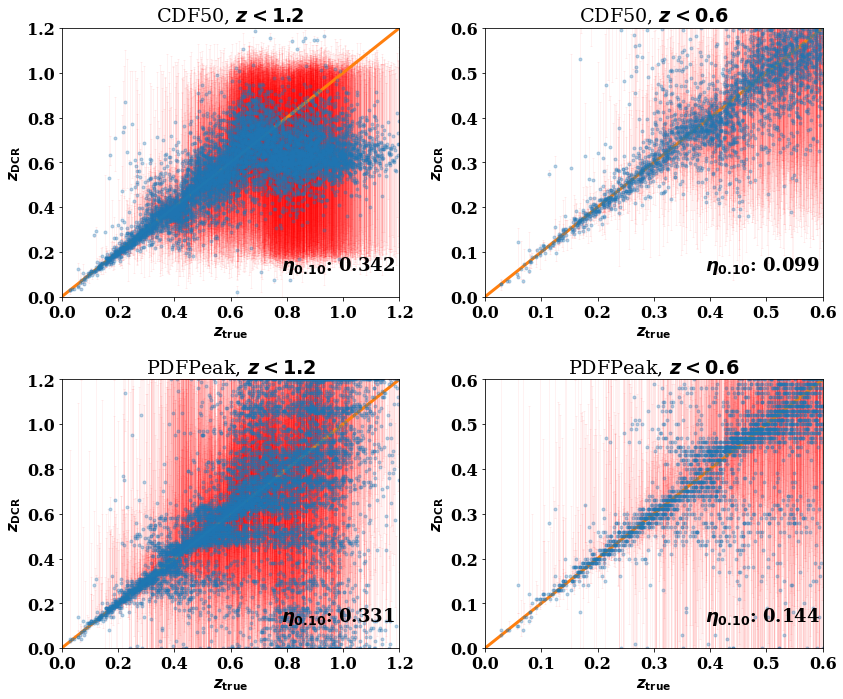

In [31]:
#3 bands with SNR > 8

fig, axs = plt.subplots(2, 2, figsize = [12, 10])

alpha_val, ebar_width, zcuts = 0.07, 0.7, [1.2, 0.6]

for t in range(len(axs[0])):
    for z in range(len(zcuts)):
        where_z_true_below_zcut = np.where(z_true[where_epoch_and_SNR] <= zcuts[z])[0]
        z_true_vals, z_pred_vals = z_true[where_epoch_and_SNR][where_z_true_below_zcut], z_preds_wrt_zY_combined_with_lcfit_tobs[t][where_epoch_and_SNR][where_z_true_below_zcut].transpose()[0]
        lower, higher = abs(z_preds_wrt_zY_combined_with_lcfit_tobs[t][where_epoch_and_SNR][where_z_true_below_zcut].transpose()[0] - z_preds_wrt_zY_combined_with_lcfit_tobs[t][where_epoch_and_SNR][where_z_true_below_zcut].transpose()[1:])
        markers, caps, bars = axs[t][z].errorbar(z_true_vals, z_pred_vals, yerr = [lower, higher], capsize=1, elinewidth=ebar_width, markeredgewidth=1, fmt='.', ecolor='red', capthick=1, alpha = 0.3)
        [bar.set_alpha(alpha_val) for bar in bars]
        [cap.set_alpha(alpha_val) for cap in caps]
        axs[t][z].plot(np.arange(0.00, 1.21, 0.01), np.arange(0.00, 1.21, 0.01), '-', lw = 3)

        axs[t][z].set_xlabel('$z_{\mathrm{true}}$', fontsize = 15)
        axs[t][z].set_ylabel('$z_{\mathrm{DCR}}$', fontsize = 15)
        
        #axs[t][z].text(0.7, 0.25, r'$\eta_{0.05}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.05), transform=axs[t][z].transAxes)
        axs[t][z].text(0.65, 0.10, r'$\eta_{0.10}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.10), transform=axs[t][z].transAxes, fontsize = 18)
        #axs[t][z].text(0.7, 0.05, r'$\eta_{0.20}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.20), transform=axs[t][z].transAxes)
       
        axs[t][z].set_xlim(0.0, zcuts[z])
        axs[t][z].set_ylim(0.0, zcuts[z])
        axs[0][z].set_title(r'CDF50, $z < %.1f$' %zcuts[z])
        axs[1][z].set_title(r'PDFPeak, $z < %.1f$' %zcuts[z])

plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/for_IR_Apr2024/zDCR_vs_ztrue_realistic_default_cut.png', dpi = 100)


In [32]:
#What result should I show as default here??? Going with LCFIT+z converged + fmax_clump for default cut 

-0.03401464702123919 -0.049014929358526
Outlier rate: 0.5534678728833218 0 All z
4.6624003398113255e-06 0.0065573099528533135
Outlier rate: 0.27629911280101394 0 $z < 0.6$
-0.003321037391994828 -0.02718858027427416
Outlier rate: 0.511134307585247 1 All z
0.002524030467650283 0.006472397442718203
Outlier rate: 0.28168567807351075 1 $z < 0.6$


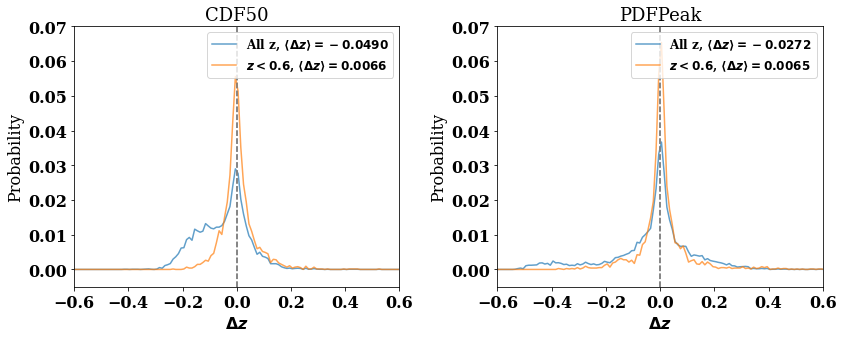

In [33]:
#Marginalizing no z-band average offset assumed, cdf 50 vs peaks

font = {'family' : 'serif',
        'weight' : 'bold',
        'style'  : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

plt.subplots(1, 2, figsize = [12, 5])

b_width = 0.01

type_strs = [r'CDF50', r'PDFPeak']
label_str = [r'All z', r'$z < 0.6$']

for t in range(len(axs[0])):
    plt.subplot(1, 2, t+1)
    for z in range(len(zcuts)):
        where_z_true_below_zcut = np.where(z_true[where_epoch_and_SNR] <= zcuts[z])[0]
        z_true_vals, z_pred_vals = z_true[where_epoch_and_SNR][where_z_true_below_zcut], z_preds_wrt_zY_combined_with_lcfit_tobs[t][where_epoch_and_SNR][where_z_true_below_zcut].transpose()[0]
        #print(len(z_pred_vals))
        Delta_z_over_z = (z_pred_vals - z_true_vals)/(1 + z_true_vals)
        y_vals, x_vals = np.histogram(Delta_z_over_z, bins = np.arange(-1.2, 1.2, b_width), density = True)

        plt.plot(x_vals[1:] - b_width/2, y_vals/len(y_vals), '-', label = label_str[z] + r', $\langle \Delta z \rangle = %.4f$' %np.mean(Delta_z_over_z.value), alpha = 0.7)
        print(np.median(Delta_z_over_z.value), np.mean(Delta_z_over_z.value))
        
        print("Outlier rate:", len(np.where(abs(Delta_z_over_z.value)>0.05)[0])/len(Delta_z_over_z.value), t, label_str[z])
        plt.xlim(-0.6, 0.6)
        plt.ylim(-0.005, 0.07)

        plt.xlabel(r'$\Delta z$')
        plt.ylabel('Probability')
        plt.axvline(x = 0,ls = '--',  color = 'gray')
        plt.title(type_strs[t], fontsize = 18)
    plt.legend(fontsize = 12, loc = 'upper right')

plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/for_IR_Apr2024/histograms_residuals_realistic_default_cut.png', dpi = 100)


In [41]:
where_z_host_unconstrained = np.where(z_preds_photo_z[1].transpose()[0][where_epoch_and_SNR] == 0)[0]

In [61]:
where_z_host_unconstrained.shape

(451,)

In [62]:
where_z_host_unconstrained_v2 = np.where(z_preds_photo_z[0].transpose()[0][where_epoch_and_SNR] != 0.595)[0]

In [63]:
where_z_host_unconstrained_v2.shape

(8168,)

In [60]:
where_z_host_unconstrained_v2.shape

(454,)

In [56]:
np.where(np.isclose(z_preds_photo_z[0].transpose()[where_epoch_and_SNR][0], 0.6, rtol = 1e-3))[0]

array([ 1303,  1339,  2152,  2333,  2493,  5763,  6160,  6522,  7238,
        8327,  8951,  9230,  9740, 10054, 10996, 11422, 12007, 12468,
       12918, 12920, 13106, 13121, 13462, 13540, 13597, 14416, 15728,
       16166, 16834, 17067, 17496, 17846, 17891, 18464, 18774, 18802,
       19186])

In [65]:
z_preds_photo_z[0].transpose()[0][where_epoch_and_SNR][where_z_host_unconstrained];

In [44]:
where_z_host_unconstrained_v2

array([], dtype=int64)

In [42]:
where_z_host_unconstrained.shape

(451,)

In [66]:
where_z_host_constrained = np.where(z_preds_photo_z[0].transpose()[0][where_epoch_and_SNR] != 0.595)[0]

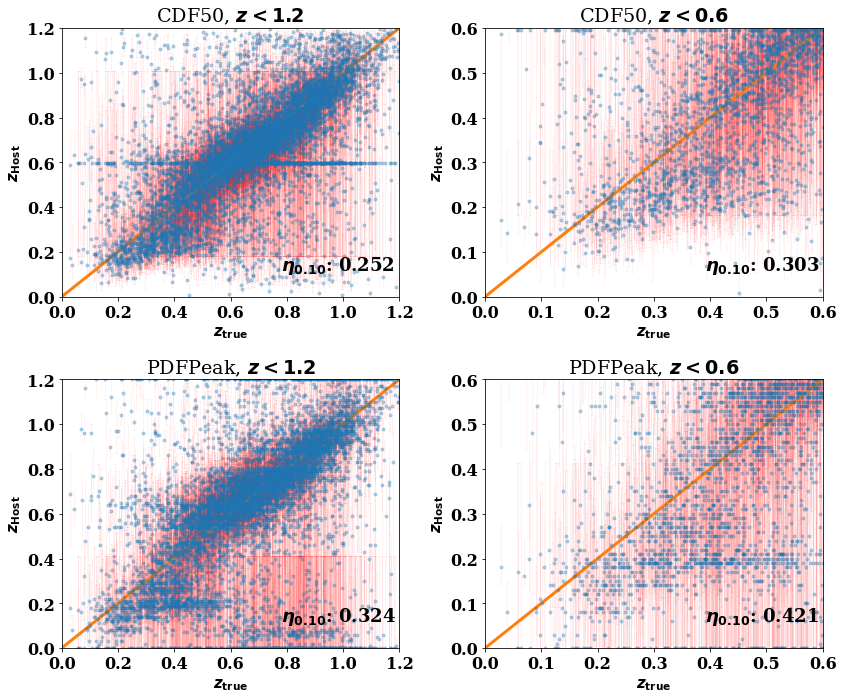

In [64]:
#Gal PhotoZ epoch and SNR

fig, axs = plt.subplots(2, 2, figsize = [12, 10])

alpha_val, ebar_width, zcuts = 0.07, 0.7, [1.2, 0.6]

for t in range(len(axs[0])):
    for z in range(len(zcuts)):
        where_z_true_below_zcut = np.where(z_true[where_epoch_and_SNR] <= zcuts[z])[0]
        z_true_vals, z_pred_vals = z_true[where_epoch_and_SNR][where_z_true_below_zcut], z_preds_photo_z[t][where_epoch_and_SNR][where_z_true_below_zcut].transpose()[0]
        lower, higher = abs(z_preds_photo_z[t][where_epoch_and_SNR][where_z_true_below_zcut].transpose()[0] - z_preds_photo_z[t][where_epoch_and_SNR][where_z_true_below_zcut].transpose()[1:])
        markers, caps, bars = axs[t][z].errorbar(z_true_vals, z_pred_vals, yerr = [lower, higher], capsize=1, elinewidth=ebar_width, markeredgewidth=1, fmt='.', ecolor='red', capthick=1, alpha = 0.3)
        [bar.set_alpha(alpha_val) for bar in bars]
        [cap.set_alpha(alpha_val) for cap in caps]
        axs[t][z].plot(np.arange(0.00, 1.21, 0.01), np.arange(0.00, 1.21, 0.01), '-', lw = 3)

        axs[t][z].set_xlabel('$z_{\mathrm{true}}$', fontsize = 15)
        axs[t][z].set_ylabel('$z_{\mathrm{Host}}$', fontsize = 15)
        
        #axs[t][z].text(0.7, 0.25, r'$\eta_{0.05}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.05), transform=axs[t][z].transAxes)
        axs[t][z].text(0.65, 0.10, r'$\eta_{0.10}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.10), transform=axs[t][z].transAxes, fontsize = 18)
        #axs[t][z].text(0.7, 0.05, r'$\eta_{0.20}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.20), transform=axs[t][z].transAxes)
        
        axs[t][z].set_xlim(0.0, zcuts[z])
        axs[t][z].set_ylim(0.0, zcuts[z])
        axs[0][z].set_title(r'CDF50, $z < %.1f$' %zcuts[z])
        axs[1][z].set_title(r'PDFPeak, $z < %.1f$' %zcuts[z])

plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/for_IR_Apr2024/zHost_vs_ztrue_realistic_default_cut.png', dpi = 100)


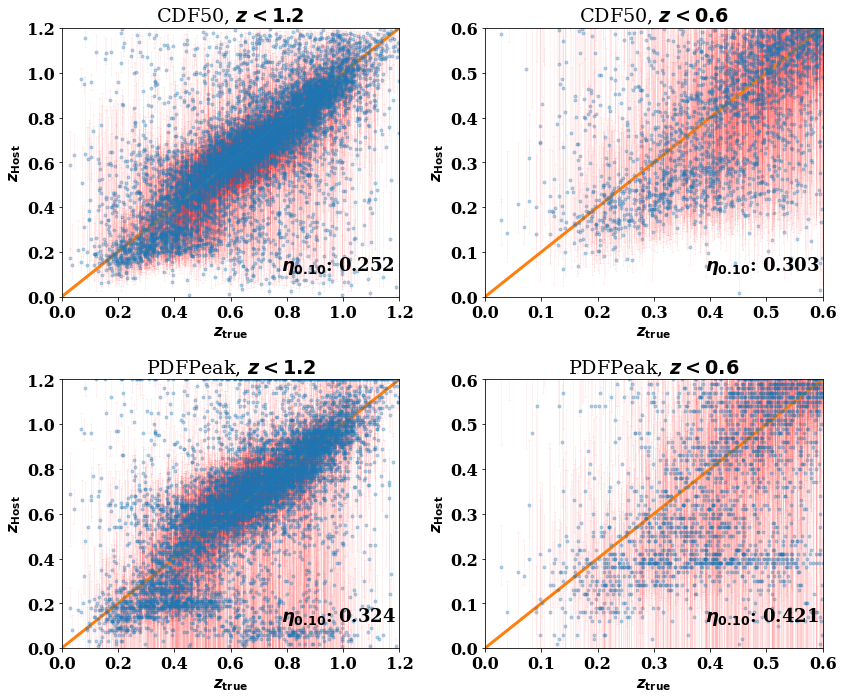

In [67]:
#Gal PhotoZ epoch and SNR

fig, axs = plt.subplots(2, 2, figsize = [12, 10])

alpha_val, ebar_width, zcuts = 0.07, 0.7, [1.2, 0.6]

for t in range(len(axs[0])):
    for z in range(len(zcuts)):
        where_z_true_below_zcut = np.where(z_true[where_epoch_and_SNR][where_z_host_constrained] <= zcuts[z])[0]
        z_true_vals, z_pred_vals = z_true[where_epoch_and_SNR][where_z_host_constrained][where_z_true_below_zcut], z_preds_photo_z[t][where_epoch_and_SNR][where_z_host_constrained][where_z_true_below_zcut].transpose()[0]
        lower, higher = abs(z_preds_photo_z[t][where_epoch_and_SNR][where_z_host_constrained][where_z_true_below_zcut].transpose()[0] - z_preds_photo_z[t][where_epoch_and_SNR][where_z_host_constrained][where_z_true_below_zcut].transpose()[1:])
        markers, caps, bars = axs[t][z].errorbar(z_true_vals, z_pred_vals, yerr = [lower, higher], capsize=1, elinewidth=ebar_width, markeredgewidth=1, fmt='.', ecolor='red', capthick=1, alpha = 0.3)
        [bar.set_alpha(alpha_val) for bar in bars]
        [cap.set_alpha(alpha_val) for cap in caps]
        axs[t][z].plot(np.arange(0.00, 1.21, 0.01), np.arange(0.00, 1.21, 0.01), '-', lw = 3)

        axs[t][z].set_xlabel('$z_{\mathrm{true}}$', fontsize = 15)
        axs[t][z].set_ylabel('$z_{\mathrm{Host}}$', fontsize = 15)

        where_z_true_below_zcut = np.where(z_true[where_epoch_and_SNR] <= zcuts[z])[0]
        z_true_vals, z_pred_vals = z_true[where_epoch_and_SNR][where_z_true_below_zcut], z_preds_photo_z[t][where_epoch_and_SNR][where_z_true_below_zcut].transpose()[0]
        
        #axs[t][z].text(0.7, 0.25, r'$\eta_{0.05}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.05), transform=axs[t][z].transAxes)
        axs[t][z].text(0.65, 0.10, r'$\eta_{0.10}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.10), transform=axs[t][z].transAxes, fontsize = 18)
        #axs[t][z].text(0.7, 0.05, r'$\eta_{0.20}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.20), transform=axs[t][z].transAxes)
        
        axs[t][z].set_xlim(0.0, zcuts[z])
        axs[t][z].set_ylim(0.0, zcuts[z])
        axs[0][z].set_title(r'CDF50, $z < %.1f$' %zcuts[z])
        axs[1][z].set_title(r'PDFPeak, $z < %.1f$' %zcuts[z])

plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/for_IR_Apr2024/zHost_vs_ztrue_realistic_default_cut_only_constrained.png', dpi = 100)


In [31]:
dz = z_range[1] - z_range[0]

In [32]:
z_DCR_PDFs_normed = z_preds_wrt_zY_combined_with_lcfit_tobs[2].transpose()/np.sum(z_preds_wrt_zY_combined_with_lcfit_tobs[2], axis = 1)/dz 
z_Host_PDFs_normed = z_preds_photo_z[2].transpose()/np.sum(z_preds_photo_z[2], axis = 1)/dz
z_DCR_Host_PDFs_normed = z_preds_with_host_photo_z[2].transpose()/np.sum(z_preds_with_host_photo_z[2], axis = 1)/dz

/global/homes/a/astjason/.conda/envs/SN_Ia/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
def eta(A, B, dx):
    return np.sum(np.min(np.array([A, B]), axis = 0), axis = 1) * dx

In [34]:
overlap_DCR_Host = eta(z_DCR_PDFs_normed.transpose(), z_Host_PDFs_normed.transpose(), z_range[1] - z_range[0])

In [35]:
eta_values = np.array([0.3176, 0.1341, 0.0460, 0.0344, 0.0127, 0.0028]) #2, 3, 4, 3sqrt(2), 5, 6 sigmas

In [36]:
where_epoch_and_SNR_and_eta = np.intersect1d(np.where(overlap_DCR_Host > eta_values[3])[0], where_epoch_and_SNR)

In [37]:
len(where_epoch_and_SNR_and_eta)

8412

In [38]:
len(where_epoch_and_SNR_and_eta)/len(where_epoch_and_SNR)

0.9756437021572721

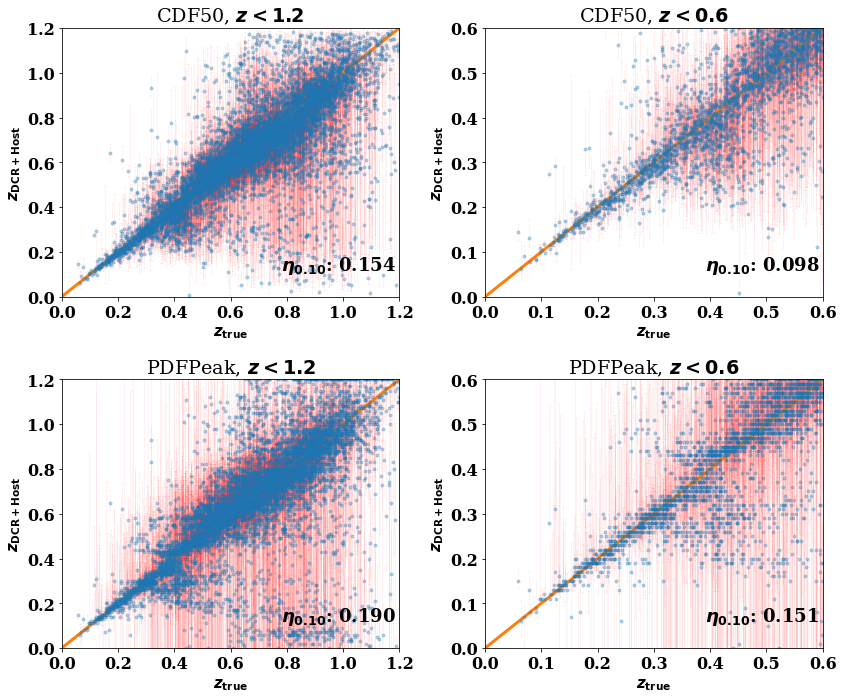

In [39]:
#Gal PhotoZ + AstroZ

fig, axs = plt.subplots(2, 2, figsize = [12, 10])

alpha_val, ebar_width, zcuts = 0.07, 0.7, [1.2, 0.6]

for t in range(len(axs[0])):
    for z in range(len(zcuts)):
        where_z_true_below_zcut = np.where(z_true[where_epoch_and_SNR_and_eta] <= zcuts[z])[0]
        z_true_vals, z_pred_vals = z_true[where_epoch_and_SNR_and_eta][where_z_true_below_zcut], z_preds_with_host_photo_z[t][where_epoch_and_SNR_and_eta][where_z_true_below_zcut].transpose()[0]
        lower, higher = abs(z_preds_with_host_photo_z[t][where_epoch_and_SNR_and_eta][where_z_true_below_zcut].transpose()[0] - z_preds_with_host_photo_z[t][where_epoch_and_SNR_and_eta][where_z_true_below_zcut].transpose()[1:])
        markers, caps, bars = axs[t][z].errorbar(z_true_vals, z_pred_vals, yerr = [lower, higher], capsize=1, elinewidth=ebar_width, markeredgewidth=1, fmt='.', ecolor='red', capthick=1, alpha = 0.3)
        [bar.set_alpha(alpha_val) for bar in bars]
        [cap.set_alpha(alpha_val) for cap in caps]
        axs[t][z].plot(np.arange(0.00, 1.21, 0.01), np.arange(0.00, 1.21, 0.01), '-', lw = 3)

        axs[t][z].set_xlabel('$z_{\mathrm{true}}$', fontsize = 15)
        axs[t][z].set_ylabel('$z_{\mathrm{DCR+Host}}$', fontsize = 15)
        
        #axs[t][z].text(0.7, 0.25, r'$\eta_{0.05}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.05), transform=axs[t][z].transAxes)
        axs[t][z].text(0.65, 0.10, r'$\eta_{0.10}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.10), transform=axs[t][z].transAxes, fontsize = 18)
        #axs[t][z].text(0.7, 0.05, r'$\eta_{0.20}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.20), transform=axs[t][z].transAxes)
        
        axs[t][z].set_xlim(0.0, zcuts[z])
        axs[t][z].set_ylim(0.0, zcuts[z])
        axs[0][z].set_title(r'CDF50, $z < %.1f$' %zcuts[z])
        axs[1][z].set_title(r'PDFPeak, $z < %.1f$' %zcuts[z])

plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/for_IR_Apr2024/zDCR+Host_vs_ztrue_realistic_default_cut.png', dpi = 100)


In [40]:
len(where_epoch_and_SNR)

8622

In [41]:
#Combining with SN Photo-z's

In [44]:
photoz_dirs = []
photoz_strs = ['LCFIT+z_OUTPUT_REALISTIC_SN_PHOTOZ_ONLY/', 'LCFIT+z_OUTPUT_REALISTIC_HOSTZ_PRIOR/', 'LCFIT+z_OUTPUT_REALISTIC_ASTROZ_PRIOR/', 'LCFIT+z_OUTPUT_REALISTIC_ASTROZ+HOSTZ_PRIOR/', 'LCFIT+z_OUTPUT_REALISTIC_SN_PHOTOZ_ONLY_COSMOLOGY_PRIOR_CORRECT_MUERRSCALE/']
for i in range(len(photoz_strs)):
    photoz_dirs.append('lcfit+z/NITER3_IR_Apr2024/' + photoz_strs[i] + 'JASON_DCR_ASTROZ_COADD_REALISTIC_v1113/')

In [45]:
skiprows = 11

FITRES_output_no_prior = pd.read_csv(photoz_dirs[0] + 'FITOPT000.FITRES', skiprows=skiprows, delim_whitespace=True)

FITRES_output_host_z_prior = pd.read_csv(photoz_dirs[1] + 'FITOPT000.FITRES', skiprows=skiprows, delim_whitespace=True)

FITRES_output_astro_z_prior = pd.read_csv(photoz_dirs[2] + 'FITOPT000.FITRES', skiprows=skiprows, delim_whitespace=True)

FITRES_output_astro_z_host_z_prior = pd.read_csv(photoz_dirs[3] + 'FITOPT000.FITRES', skiprows=skiprows, delim_whitespace=True)

FITRES_output_no_prior_cosmology_prior = pd.read_csv(photoz_dirs[4] + 'FITOPT000.FITRES', skiprows=skiprows, delim_whitespace=True)

In [47]:
where_no_prior_fit = FITRES_output_no_prior['CID'][np.where(np.isnan(FITRES_output_no_prior['zHD'])== False)[0]].astype(int).values - 1
where_host_z_prior_fit = FITRES_output_host_z_prior['CID'][np.where(np.isnan(FITRES_output_host_z_prior['zHD'])== False)[0]].astype(int) - 1
where_astro_z_prior_fit = FITRES_output_astro_z_prior['CID'][np.where(np.isnan(FITRES_output_astro_z_prior['zHD'])== False)[0]].astype(int) - 1
where_astro_z_host_z_prior_fit = FITRES_output_astro_z_host_z_prior['CID'][np.where(np.isnan(FITRES_output_astro_z_host_z_prior['zHD'])== False)[0]].astype(int) - 1
where_no_prior_fit_cosmology_prior = FITRES_output_no_prior_cosmology_prior['CID'][np.where(np.isnan(FITRES_output_no_prior_cosmology_prior['zHD'])== False)[0]].astype(int) - 1

In [48]:
lcfit_types = [where_no_prior_fit, where_host_z_prior_fit.values, where_astro_z_prior_fit.values, where_astro_z_host_z_prior_fit.values, where_no_prior_fit_cosmology_prior.values]
z_pred_types = [FITRES_output_no_prior['zHD'].values[np.where(np.isnan(FITRES_output_no_prior['zHD'])== False)[0]], FITRES_output_host_z_prior['zHD'].values[np.where(np.isnan(FITRES_output_host_z_prior['zHD'])== False)[0]], FITRES_output_astro_z_prior['zHD'].values[np.where(np.isnan(FITRES_output_astro_z_prior['zHD'])== False)[0]], FITRES_output_astro_z_host_z_prior['zHD'].values[np.where(np.isnan(FITRES_output_astro_z_host_z_prior['zHD'])== False)[0]], FITRES_output_no_prior_cosmology_prior['zHD'].values[np.where(np.isnan(FITRES_output_no_prior_cosmology_prior['zHD'])== False)[0]]]
z_err_types = [FITRES_output_no_prior['zHDERR'].values[np.where(np.isnan(FITRES_output_no_prior['zHDERR'])== False)[0]], FITRES_output_host_z_prior['zHDERR'].values[np.where(np.isnan(FITRES_output_host_z_prior['zHDERR'])== False)[0]], FITRES_output_astro_z_prior['zHDERR'].values[np.where(np.isnan(FITRES_output_astro_z_prior['zHDERR'])== False)[0]], FITRES_output_astro_z_host_z_prior['zHDERR'].values[np.where(np.isnan(FITRES_output_astro_z_host_z_prior['zHDERR'])== False)[0]], FITRES_output_no_prior_cosmology_prior['zHDERR'].values[np.where(np.isnan(FITRES_output_no_prior_cosmology_prior['zHDERR'])== False)[0]]]

In [97]:
print(np.mean(z_err_types[0]), np.median(z_err_types[0]))
print(np.mean(FITRES_output_no_prior['cERR'][1:]), np.median(FITRES_output_no_prior['cERR'][1:]))
print(np.mean(FITRES_output_no_prior['x1ERR'][1:]), np.median(FITRES_output_no_prior['x1ERR'][1:]))

0.017267449360552863 0.01142
0.05277707172293269 0.0408332
0.6759450472213852 0.57134


In [50]:
print(np.mean(FITRES_output_astro_z_host_z_prior['cERR'][1:]), np.median(FITRES_output_astro_z_host_z_prior['cERR'][1:]))
print(np.mean(FITRES_output_astro_z_host_z_prior['x1ERR'][1:]), np.median(FITRES_output_astro_z_host_z_prior['x1ERR'][1:]))

0.05025333473667748 0.0396159
0.6760994000133048 0.56071


In [51]:
FITPROB_types = [FITRES_output_no_prior['FITPROB'].values[np.where(np.isnan(FITRES_output_no_prior['FITPROB'])== False)[0]], FITRES_output_host_z_prior['FITPROB'].values[np.where(np.isnan(FITRES_output_host_z_prior['FITPROB'])== False)[0]], FITRES_output_astro_z_prior['FITPROB'].values[np.where(np.isnan(FITRES_output_astro_z_prior['FITPROB'])== False)[0]], FITRES_output_astro_z_host_z_prior['FITPROB'].values[np.where(np.isnan(FITRES_output_astro_z_host_z_prior['FITPROB'])== False)[0]], FITRES_output_no_prior_cosmology_prior['FITPROB'].values[np.where(np.isnan(FITRES_output_no_prior_cosmology_prior['FITPROB'])== False)[0]]]

In [52]:
lcfit_types_cut = []
for i in range(len(lcfit_types)):
    lcfit_types_cut.append(lcfit_types[i][np.intersect1d(where_epoch_and_SNR, lcfit_types[i], return_indices=True)[2]])

In [53]:
lcfit_types_cut_FITPROB = []
for i in range(len(lcfit_types)):
    lcfit_types_cut_FITPROB.append(lcfit_types[i][np.where(FITPROB_types[i]>=0.01)[0]][np.intersect1d(where_epoch_and_SNR, lcfit_types[i][np.where(FITPROB_types[i]>=0.01)[0]], return_indices=True)[2]])

In [54]:
for i in range(len(lcfit_types)):
    print(len(lcfit_types[i]), len(lcfit_types_cut[i]), len(lcfit_types_cut_FITPROB[i]))

12589 7295 6657
12324 7176 6615
12246 7660 7255
12779 7568 7215
13946 7790 7276


In [55]:
lcfit_types_intersecting_inds_from_cut = []
for i in range(len(lcfit_types)):
    lcfit_types_intersecting_inds_from_cut.append(np.intersect1d(lcfit_types[i], lcfit_types_cut[i], return_indices=True)[1])

In [56]:
type_strs_with_lcfit = ['no_prior', 'host_prior', 'astro-z_prior', 'host_astro-z_prior', 'no_prior_cosmology_prior']

In [57]:
z_pred_types_cut, z_err_types_cut = [], []
for i in range(len(z_pred_types)):
    z_pred_types_cut.append(z_pred_types[i][np.intersect1d(where_epoch_and_SNR, lcfit_types[i], return_indices=True)[2]])
    z_err_types_cut.append(z_err_types[i][np.intersect1d(where_epoch_and_SNR, lcfit_types[i], return_indices=True)[2]])


In [58]:
z_pred_types_cut_FITPROB, z_err_types_cut_FITPROB = [], []
for i in range(len(z_pred_types)):
    z_pred_types_cut_FITPROB.append(z_pred_types[i][np.where(FITPROB_types[i]>=0.01)[0]][np.intersect1d(where_epoch_and_SNR, lcfit_types[i][np.where(FITPROB_types[i]>=0.01)[0]], return_indices=True)[2]])
    z_err_types_cut_FITPROB.append(z_err_types[i][np.where(FITPROB_types[i]>=0.01)[0]][np.intersect1d(where_epoch_and_SNR, lcfit_types[i][np.where(FITPROB_types[i]>=0.01)[0]], return_indices=True)[2]])

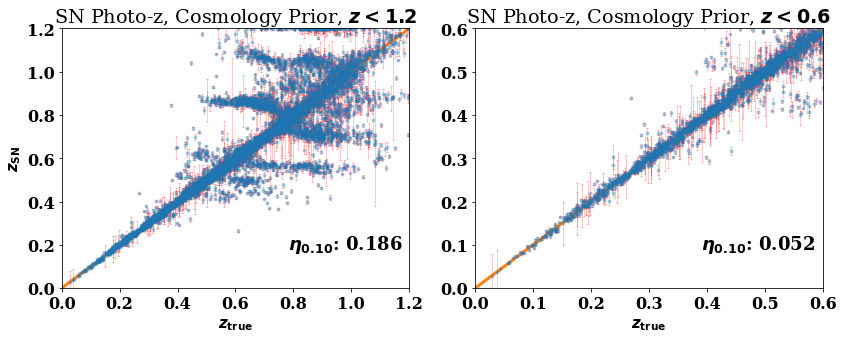

In [59]:
#All with lcfit converged + S/N cut for paper

#font = {'size'   : 14}
#matplotlib.rc('font', **font)
fig, axs = plt.subplots(1, 2, figsize = [12, 5])

alpha_val, ebar_width, zcuts = 0.07, 0.7, [1.2, 0.6]

for t in range(1):
    for z in range(len(zcuts)):
        where_z_true_below_zcut = np.where(z_true[lcfit_types_cut_FITPROB[4]] <= zcuts[z])[0]
        z_true_vals, z_pred_vals = z_true[lcfit_types_cut_FITPROB[4]][where_z_true_below_zcut], z_pred_types_cut_FITPROB[4][where_z_true_below_zcut]
        #lower, higher = abs(z_preds[t][where_epoch_and_SNR][where_z_true_below_zcut].transpose()[0] - z_preds[t][where_epoch_and_SNR][where_z_true_below_zcut].transpose()[1:])
        markers, caps, bars = axs[z].errorbar(z_true_vals, z_pred_vals, yerr = z_err_types_cut_FITPROB[4][where_z_true_below_zcut], capsize=1, elinewidth=ebar_width, markeredgewidth=1, fmt='.', ecolor='red', capthick=1, alpha = 0.3)
        axs[z].plot(np.arange(0.00, 1.21, 0.01), np.arange(0.00, 1.21, 0.01), '-', lw = 3)
        if t == len(axs) - 2:
            axs[z].set_xlabel('$z_{\mathrm{true}}$', fontsize = 15)
        if z == 0:
            axs[z].set_ylabel('$z_{\mathrm{SN}}$', fontsize = 15)
            #axs[4][z].set_ylabel('$z_{\mathrm{SN+DCR+Host}}$', fontsize = 15)
        
        #axs[z].text(0.7, 0.25, r'$\eta_{0.05}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.05), transform=axs[z].transAxes)
        axs[z].text(0.65, 0.15, r'$\eta_{0.10}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.10), transform=axs[z].transAxes, fontsize = 18)
        #axs[z].text(0.7, 0.05, r'$\eta_{0.20}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.20), transform=axs[z].transAxes)
        
        axs[z].set_xlim(0.0, zcuts[z])
        axs[z].set_ylim(0.0, zcuts[z])
        axs[z].set_title(r'SN Photo-z, Cosmology Prior, $z < %.1f$' %zcuts[z])
        #axs[4][z].set_title(r'With cosmology prior, $z < %.1f$' %zcuts[z])

plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/for_IR_Apr2024/zSN_vs_ztrue_realistic_cosmology_prior.png', dpi = 100)


In [60]:
def index_outlier(z_true_values, z_pred_values, precision):
    where_outlier = np.where(abs((z_pred_values - z_true_values)/(1 + z_true_values)) > precision)[0]
    where_not_outlier = np.where(abs((z_pred_values - z_true_values)/(1 + z_true_values)) <= precision)[0]
    return where_outlier, where_not_outlier

In [61]:
lcfit_types_intersecting_inds_from_cut_FITPROB = []
for i in range(len(lcfit_types)):
    lcfit_types_intersecting_inds_from_cut_FITPROB.append(np.intersect1d(lcfit_types[i], lcfit_types_cut_FITPROB[i], return_indices=True)[1])

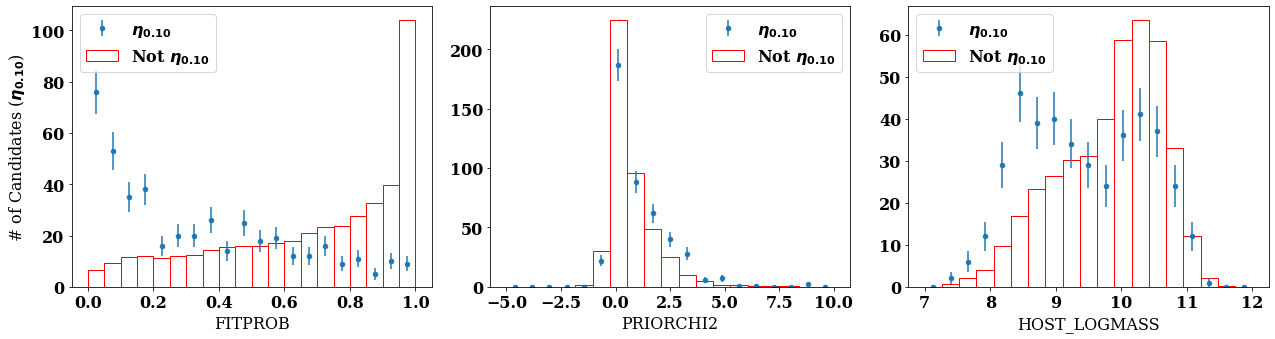

In [90]:
font = {'size'   : 16}
matplotlib.rc('font', **font)

outlier_precision = 0.10

outlier_inds, not_outlier_inds = index_outlier(z_true[lcfit_types_cut_FITPROB[3]].value, z_pred_types_cut_FITPROB[3], outlier_precision)

outlier_events, non_outlier_events = [], []
outliers_hist, non_outliers_hist = [], []
diag_strs = ['FITPROB', 'PRIORCHI2', 'HOST_LOGMASS']
bin_ranges = [np.arange(0.00, 1.05, 0.05), np.linspace(-5, 10, num = 20), np.linspace(7, 12, num = 20)]

plt.subplots(1, 3, figsize = [18, 5])

for i in range(len(diag_strs)):
    outliers_hist.append(np.histogram(FITRES_output_astro_z_host_z_prior[diag_strs[i]].values[lcfit_types_intersecting_inds_from_cut_FITPROB[3] + 1][outlier_inds], bins = bin_ranges[i]))
    #outliers_bin_indices = np.digitize(FITRES_output_astro_z_host_z_prior[diag_strs[i]].values[lcfit_types_intersecting_inds_from_cut_FITPROB[3] + 1][outlier_inds], bins = bin_ranges[i])
    #stdv_per_bin = [np.std(FITRES_output_astro_z_host_z_prior[diag_strs[i]].values[lcfit_types_intersecting_inds_from_cut_FITPROB[3] + 1][outlier_inds][outliers_bin_indices == j]) for j in range(1, len(bin_ranges[i]))]
    #np.array(stdv_per_bin)[np.isnan(stdv_per_bin)] = 0
    non_outliers_hist.append(np.histogram(FITRES_output_astro_z_host_z_prior[diag_strs[i]].values[lcfit_types_intersecting_inds_from_cut_FITPROB[3] + 1][not_outlier_inds], bins = bin_ranges[i]))

    bin_size = outliers_hist[i][1][1] - outliers_hist[i][1][0]
    plt.subplot(1, 3, i+1)
    plt.errorbar(outliers_hist[i][1][:-1] + bin_size/2, outliers_hist[i][0], yerr = np.sqrt(outliers_hist[i][0]), fmt = '.', ms = 9, label = r'$\eta_{%.2f}$' %outlier_precision)
    plt.bar(non_outliers_hist[i][1][:-1] + bin_size/2, non_outliers_hist[i][0]/np.sum(non_outliers_hist[i][0])*np.sum(outliers_hist[i][0]), width = bin_size, color = 'None', edgecolor = 'red', label = r'Not $\eta_{%.2f}$' %outlier_precision)
    plt.xlabel(diag_strs[i])
    if i == 0:
        plt.ylabel(r'# of Candidates ($\eta_{0.10}$)')
    plt.legend()
    outlier_events.append(outliers_hist[i][0])
    non_outlier_events.append(non_outliers_hist[i][0])
    
plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/for_IR_Apr2024/Diagonstics_Histograms_z_SN+DCR+Host_%.2f.png' %outlier_precision, dpi = 100, facecolor = 'white')

In [64]:
SNRs_sum = np.zeros(len(SNRs_all))

for i in range(len(SNRs_sum)):
    for j in range(len(no_obs_all[0])):
        SNRs_sum[i] += SNRs_all[i][j].sum()

In [65]:
lcfit_types_intersecting_inds_from_cut_FITPROB = []
for i in range(len(lcfit_types)):
    lcfit_types_intersecting_inds_from_cut_FITPROB.append(np.intersect1d(lcfit_types[i], lcfit_types_cut_FITPROB[i], return_indices=True)[1])

In [66]:
#z_DCR, z_Host, z_DCR+Host
z_preds_pdf_without_SN_photoz = np.array([z_Host_PDFs_normed.transpose(), z_DCR_PDFs_normed.transpose(), z_DCR_Host_PDFs_normed.transpose()])

In [67]:
def normal_dist(x , mean , sd):
    if len(mean) > 1:
        # Define the shape of the 2D array
        shape = (len(x), len(mean))
        # Use broadcasting to create the 2D array
        x = x.reshape((len(x), 1)) * np.ones(shape)
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return (prob_density/np.sum(prob_density, axis = 0)).transpose()


In [68]:
x_range = np.linspace(0, 1.2, num = 121)

SN_photoz_only_pdfs_cut = normal_dist(x_range, z_pred_types_cut[0], z_err_types_cut[0])

ind_overlap_with_SN_photoz = []
eta_with_SN_photoz = []
where_not_eta_condition_with_SN_photoz, where_eta_condition_with_SN_photoz = [], []
for i in range(len(lcfit_types_cut)-2):
    ind_overlap_with_SN_photoz.append(np.intersect1d(lcfit_types_cut[0], lcfit_types_cut[i+1]))
    eta_with_SN_photoz.append(eta(SN_photoz_only_pdfs_cut, z_preds_pdf_without_SN_photoz[i][lcfit_types_cut[0]], dz))
    where_not_eta_condition_with_SN_photoz.append(np.where(eta_with_SN_photoz[i] < eta_values[3])[0])
    where_eta_condition_with_SN_photoz.append(np.where(eta_with_SN_photoz[i] >= eta_values[3])[0])

In [69]:
where_epoch_and_SNR_and_eta = np.intersect1d(np.where(overlap_DCR_Host >= eta_values[3])[0], where_epoch_and_SNR)
where_epoch_and_SNR_and_not_eta = np.intersect1d(np.where(overlap_DCR_Host < eta_values[3])[0], where_epoch_and_SNR)

In [70]:
where_z_DCR_Host_not_compatible_for_combined_FITPROB = np.intersect1d(lcfit_types_cut_FITPROB[3], where_epoch_and_SNR_and_not_eta, return_indices= True)

In [71]:
where_z_DCR_Host_not_compatible_for_combined_z_DCR_prior_FITPROB = np.intersect1d(lcfit_types_cut_FITPROB[2], where_z_DCR_Host_not_compatible_for_combined_FITPROB[0], return_indices = True)
where_z_DCR_Host_not_compatible_for_combined_z_Host_prior_FITPROB = np.intersect1d(lcfit_types_cut_FITPROB[1], where_z_DCR_Host_not_compatible_for_combined_FITPROB[0], return_indices = True)

In [72]:
where_z_DCR_Host_not_compatible_but_lcfit_converged_FITPROB = np.intersect1d(where_z_DCR_Host_not_compatible_for_combined_z_Host_prior_FITPROB[0], where_z_DCR_Host_not_compatible_for_combined_z_DCR_prior_FITPROB, return_indices= True)
where_z_DCR_Host_not_compatible_but_lcfit_converged_eta_available_FITPROB = np.intersect1d(lcfit_types_cut_FITPROB[0], where_z_DCR_Host_not_compatible_but_lcfit_converged_FITPROB[0], return_indices = True)

In [73]:
overlap_with_SN_photozs_incompatible_DCR_Host_FITPROB = np.zeros([2, len(where_z_DCR_Host_not_compatible_but_lcfit_converged_eta_available_FITPROB[1])])

for i in range(2):
    overlap_with_SN_photozs_incompatible_DCR_Host_FITPROB[i] = eta_with_SN_photoz[i][where_z_DCR_Host_not_compatible_but_lcfit_converged_eta_available_FITPROB[1]].copy()

max_etas = np.maximum(overlap_with_SN_photozs_incompatible_DCR_Host_FITPROB[0], overlap_with_SN_photozs_incompatible_DCR_Host_FITPROB[1])

max_array = np.argmax(overlap_with_SN_photozs_incompatible_DCR_Host_FITPROB, axis=0)

indices_where_max_eta = [np.where(max_array == i)[0] for i in range(2)]


In [74]:
where_z_DCR_Host_not_compatible_but_lcfit_converged_eta_available_for_all_combined_FITPROB = np.intersect1d(lcfit_types_cut_FITPROB[3], lcfit_types_cut_FITPROB[0][where_z_DCR_Host_not_compatible_but_lcfit_converged_eta_available_FITPROB[1]], return_indices=True)
indices_common_elements_all_combined_eta_FITPROB = [where_z_DCR_Host_not_compatible_for_combined_z_Host_prior_FITPROB[1], where_z_DCR_Host_not_compatible_for_combined_z_DCR_prior_FITPROB[1], where_z_DCR_Host_not_compatible_but_lcfit_converged_eta_available_for_all_combined_FITPROB[1]]

In [75]:

# Assuming indices_common_elements and indices_where_max_eta are defined
z_pred_all_combined_cut_with_eta_considered_for_incompatible_priors_FITPROB = z_pred_types_cut_FITPROB[3].copy()
z_err_all_combined_cut_with_eta_considered_for_incompatible_priors_FITPROB = z_err_types_cut_FITPROB[3].copy()

z_pred_all_combined_cut_with_eta_considered_for_incompatible_priors_FITPROB[where_z_DCR_Host_not_compatible_for_combined_FITPROB[1][where_z_DCR_Host_not_compatible_for_combined_z_DCR_prior_FITPROB[2]]] = np.copy(z_pred_types_cut_FITPROB[2][where_z_DCR_Host_not_compatible_for_combined_z_DCR_prior_FITPROB[1]])
z_pred_all_combined_cut_with_eta_considered_for_incompatible_priors_FITPROB[where_z_DCR_Host_not_compatible_for_combined_FITPROB[1][where_z_DCR_Host_not_compatible_for_combined_z_Host_prior_FITPROB[2]]] = np.copy(z_pred_types_cut_FITPROB[1][where_z_DCR_Host_not_compatible_for_combined_z_Host_prior_FITPROB[1]])

z_err_all_combined_cut_with_eta_considered_for_incompatible_priors_FITPROB[where_z_DCR_Host_not_compatible_for_combined_FITPROB[1][where_z_DCR_Host_not_compatible_for_combined_z_DCR_prior_FITPROB[2]]] = np.copy(z_err_types_cut_FITPROB[2][where_z_DCR_Host_not_compatible_for_combined_z_DCR_prior_FITPROB[1]])
z_err_all_combined_cut_with_eta_considered_for_incompatible_priors_FITPROB[where_z_DCR_Host_not_compatible_for_combined_FITPROB[1][where_z_DCR_Host_not_compatible_for_combined_z_Host_prior_FITPROB[2]]] = np.copy(z_err_types_cut_FITPROB[1][where_z_DCR_Host_not_compatible_for_combined_z_Host_prior_FITPROB[1]])

for i in range(2):
#    # Explicitly use np.copy() to ensure a new array is created
    z_err_all_combined_cut_with_eta_considered_for_incompatible_priors_FITPROB[indices_common_elements_all_combined_eta_FITPROB[2][indices_where_max_eta[i]]] = np.copy(z_pred_types_cut_FITPROB[i+1][indices_common_elements_all_combined_eta_FITPROB[i]][indices_where_max_eta[i]])
    z_err_all_combined_cut_with_eta_considered_for_incompatible_priors_FITPROB[indices_common_elements_all_combined_eta_FITPROB[2][indices_where_max_eta[i]]] = np.copy(z_err_types_cut_FITPROB[i+1][indices_common_elements_all_combined_eta_FITPROB[i]][indices_where_max_eta[i]])


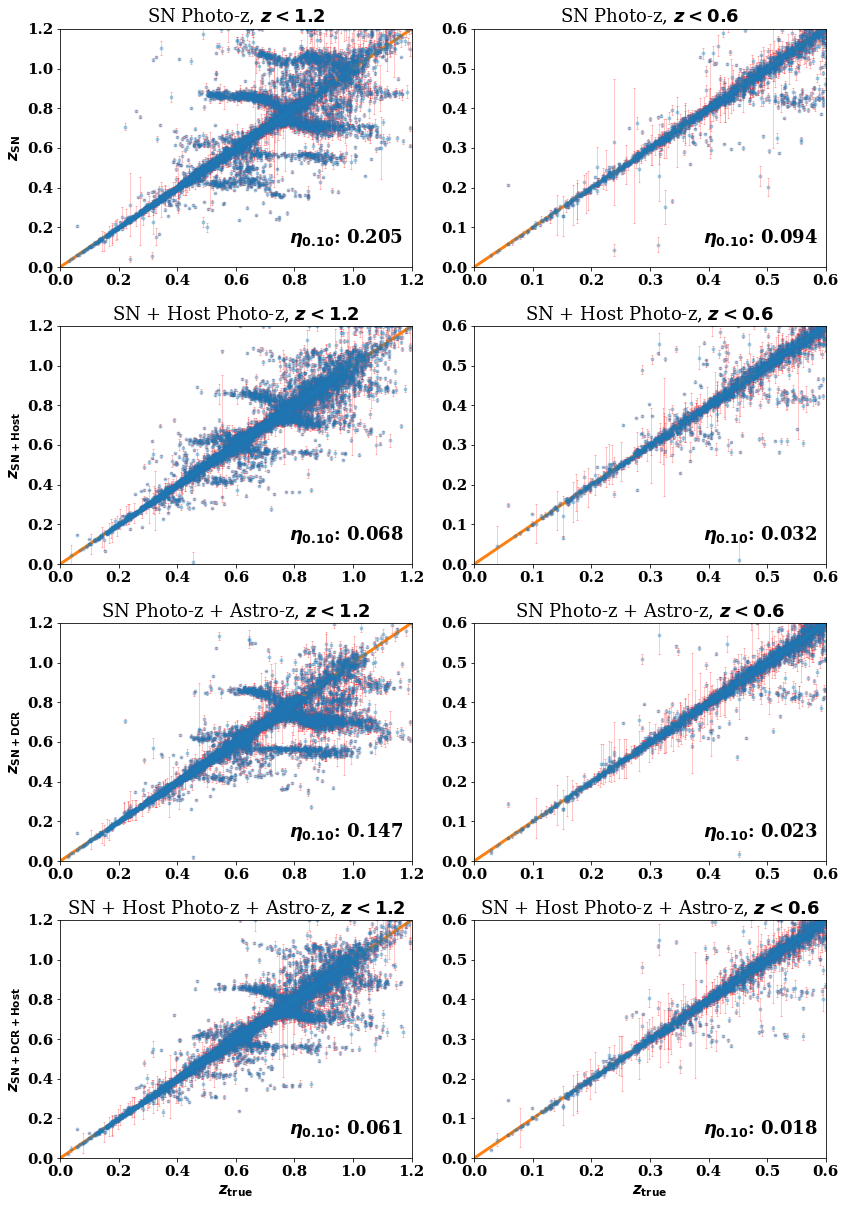

In [89]:
#All with lcfit converged + S/N cut for paper

matplotlib.rc('font', **font)
fig, axs = plt.subplots(4, 2, figsize = [12, 17])

alpha_val, ebar_width, zcuts = 0.07, 0.7, [1.2, 0.6]

for t in range(len(axs)):
    for z in range(len(zcuts)):
        where_z_true_below_zcut = np.where(z_true[lcfit_types_cut_FITPROB[t]] <= zcuts[z])[0]
        if t == 3:
            z_true_vals, z_pred_vals = z_true[lcfit_types_cut_FITPROB[t]][where_z_true_below_zcut], z_pred_all_combined_cut_with_eta_considered_for_incompatible_priors_FITPROB[where_z_true_below_zcut]
            markers, caps, bars = axs[t][z].errorbar(z_true_vals, z_pred_vals, yerr = z_err_all_combined_cut_with_eta_considered_for_incompatible_priors_FITPROB[where_z_true_below_zcut], capsize=1, elinewidth=ebar_width, markeredgewidth=1, fmt='.', ecolor='red', capthick=1, alpha = 0.3)
        else:
            z_true_vals, z_pred_vals = z_true[lcfit_types_cut_FITPROB[t]][where_z_true_below_zcut], z_pred_types_cut_FITPROB[t][where_z_true_below_zcut]
            markers, caps, bars = axs[t][z].errorbar(z_true_vals, z_pred_vals, yerr = z_err_types_cut_FITPROB[t][where_z_true_below_zcut], capsize=1, elinewidth=ebar_width, markeredgewidth=1, fmt='.', ecolor='red', capthick=1, alpha = 0.3)
        axs[t][z].plot(np.arange(0.00, 1.21, 0.01), np.arange(0.00, 1.21, 0.01), '-', lw = 3)
        if t == len(axs) - 1:
            axs[t][z].set_xlabel('$z_{\mathrm{true}}$', fontsize = 15)
        if z == 0:
            axs[0][z].set_ylabel('$z_{\mathrm{SN}}$', fontsize = 15)
            axs[1][z].set_ylabel('$z_{\mathrm{SN+Host}}$', fontsize = 15)
            axs[2][z].set_ylabel('$z_{\mathrm{SN+DCR}}$', fontsize = 15)
            axs[3][z].set_ylabel('$z_{\mathrm{SN+DCR+Host}}$', fontsize = 15)
        
        #axs[t][z].text(0.7, 0.25, r'$\eta_{0.05}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.05), transform=axs[t][z].transAxes)
        axs[t][z].text(0.65, 0.10, r'$\eta_{0.10}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.10), transform=axs[t][z].transAxes, fontsize = 18)
        #axs[t][z].text(0.7, 0.05, r'$\eta_{0.20}$: %.3f' %outlier_rates(z_true_vals, z_pred_vals, 0.20), transform=axs[t][z].transAxes)
        
        axs[t][z].set_xlim(0.0, zcuts[z])
        axs[t][z].set_ylim(0.0, zcuts[z])
        axs[0][z].set_title(r'SN Photo-z, $z < %.1f$' %zcuts[z])
        axs[1][z].set_title(r'SN + Host Photo-z, $z < %.1f$' %zcuts[z])
        axs[2][z].set_title(r'SN Photo-z + Astro-z, $z < %.1f$' %zcuts[z])
        axs[3][z].set_title(r'SN + Host Photo-z + Astro-z, $z < %.1f$' %zcuts[z])

plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/for_IR_Apr2024/zSN_all_combinations_vs_ztrue_realistic_FITPROB_cut.png', dpi = 100)


In [77]:
lcfit_types_cut_FITPROB[2].shape

(7255,)

In [78]:
lcfit_types_cut_FITPROB[0].shape

(6657,)

In [79]:
z_DCR_z_true = z_preds_wrt_zY_combined_with_lcfit_tobs[1][lcfit_types_cut_FITPROB[0]].transpose()[0] - z_true[lcfit_types_cut_FITPROB[0]]
z_SN_z_true = z_pred_types_cut_FITPROB[0] - z_true[lcfit_types_cut_FITPROB[0]]

In [80]:
np.corrcoef(z_SN_z_true, z_DCR_z_true)

array([[1.        , 0.15177278],
       [0.15177278, 1.        ]])

In [81]:
#Need to do this 11/17

# Now adding RMS/sqrt(n) (error on the mean) [0]: Bias, [1]: RMS error, [2]: Error on the mean, [3]: Outlier rates eta_0.10, [4]: sigma_MAD
def residuals_exp_and_outliers_and_MAD(z_pred_val, z_true_val, zcut_range = np.linspace(0, 1.2, num = 13)):
    exp_vals = np.zeros([len(zcut_range)-1, 5])#, np.zeros([len(zcut_range)-1])
    for z in range(len(zcut_range)-1):
        where_z_range = np.where((z_true_val > zcut_range[z]) & (z_true_val <= zcut_range[z+1]))[0]
        true_vals, pred_vals = z_true_val[where_z_range], z_pred_val[where_z_range]
        Delta_z = (pred_vals - true_vals)/(1 + true_vals)
        exp_vals[z] = np.mean(Delta_z), np.std(Delta_z), np.std(Delta_z)/np.sqrt(len(Delta_z)), len(np.where(abs(Delta_z.value)>0.10)[0])/len(Delta_z.value), 1.4826*np.median(abs(Delta_z - np.median(Delta_z)))
    return exp_vals#, outlier_rates


#type_strs_selection = ['No selection cut', 'Default (3 bands with S/N > 8)', r'Default + at least one band with AM $\geq$ 1.4']#, 'Peaks == CDF50']
type_strs_selection = ['no_cut', 'default', 'default+AM', 'fmax_clump', 'ideal_tobs']#, 'Peaks == CDF50']

where_type = [np.arange(len(t_head)), where_epoch_and_SNR, where_epoch_and_SNR_and_AM, where_epoch_and_SNR, where_epoch_and_SNR, where_epoch_and_SNR_and_eta]#, where_both_match]type_strs = [r'50% $\pm 1\sigma$', r'Peaks $\pm 1\sigma$']

#type_strs_stat = [r'50% $\pm 1\sigma$', r'Peaks $\pm 1\sigma$']
type_strs_stat = ['CDF50', 'Peaks']

for i in range(len(type_strs_stat)):
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_SN_only_binned_eta0.10.txt' %(type_strs_selection[3], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY[i][where_type[3]].transpose()[0], z_true[where_type[3]], np.linspace(0, 1.2, num = 13)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_SN_only_binned_eta0.10.txt' %(type_strs_selection[4], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_ideal_tobs[i][where_type[4]].transpose()[0], z_true[where_type[4]], np.linspace(0, 1.2, num = 13)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_gal_only_binned_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_photo_z[i][where_type[1]].transpose()[0], z_true[where_type[1]], np.linspace(0, 1.2, num = 13)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_SN+gal_binned_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_with_host_photo_z[i][where_type[1]].transpose()[0], z_true[where_type[1]], np.linspace(0, 1.2, num = 13)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_SN+gal_binned_eta_cut_3sqrt2sigma_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_with_host_photo_z[i][where_type[5]].transpose()[0], z_true[where_type[5]], np.linspace(0, 1.2, num = 13)))    
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_SN_only_high_low_z_eta0.10.txt' %(type_strs_selection[3], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY[i][where_type[3]].transpose()[0], z_true[where_type[3]], np.linspace(0, 1.2, num = 3)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_SN_only_high_low_z_eta0.10.txt' %(type_strs_selection[4], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_ideal_tobs[i][where_type[4]].transpose()[0], z_true[where_type[4]], np.linspace(0, 1.2, num = 3)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_gal_only_high_low_z_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_photo_z[i][where_type[1]].transpose()[0], z_true[where_type[1]], np.linspace(0, 1.2, num = 3)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_SN+gal_high_low_z_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_with_host_photo_z[i][where_type[1]].transpose()[0], z_true[where_type[1]], np.linspace(0, 1.2, num = 3)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_SN+gal_high_low_z_eta_cut_3sqrt2sigma_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_with_host_photo_z[i][where_type[5]].transpose()[0], z_true[where_type[5]], np.linspace(0, 1.2, num = 3)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_SN_only_all_z_eta0.10.txt' %(type_strs_selection[3], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY[i][where_type[3]].transpose()[0], z_true[where_type[3]], np.linspace(0, 1.2, num = 2)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_SN_only_all_z_eta0.10.txt' %(type_strs_selection[4], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_ideal_tobs[i][where_type[4]].transpose()[0], z_true[where_type[4]], np.linspace(0, 1.2, num = 2)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_gal_only_all_z_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_photo_z[i][where_type[1]].transpose()[0], z_true[where_type[1]], np.linspace(0, 1.2, num = 2)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_SN+gal_all_z_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_with_host_photo_z[i][where_type[1]].transpose()[0], z_true[where_type[1]], np.linspace(0, 1.2, num = 2)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_SN+gal_all_z_eta_cut_3sqrt2sigma_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_with_host_photo_z[i][where_type[5]].transpose()[0], z_true[where_type[5]], np.linspace(0, 1.2, num = 2)))

    #np.savetxt('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_z_metrics_type_%s_%s_SN+gal_ideal_tobs.txt' %(type_strs_selection[t], type_strs_stat[i]), residuals_exp_and_outliers(z_preds_with_host_photo_z_ideal_tobs[i][where_type[t]].transpose()[0], z_true[where_type[t]]))


for t in range(len(type_strs_selection[:3])):
    for i in range(len(type_strs_stat)):
        np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_SN_only_binned_eta0.10.txt' %(type_strs_selection[t], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_combined_with_lcfit_tobs[i][where_type[t]].transpose()[0], z_true[where_type[t]], np.linspace(0, 1.2, num = 13)))
        np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_SN_only_high_low_z_eta0.10.txt' %(type_strs_selection[t], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_combined_with_lcfit_tobs[i][where_type[t]].transpose()[0], z_true[where_type[t]], np.linspace(0, 1.2, num = 3)))
        np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_%s_SN_only_all_z_eta0.10.txt' %(type_strs_selection[t], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_combined_with_lcfit_tobs[i][where_type[t]].transpose()[0], z_true[where_type[t]], np.linspace(0, 1.2, num = 2)))


In [82]:
z_est_DCR_CDF50, z_true_DCR = z_preds_wrt_zY_combined_with_lcfit_tobs[0][where_type[2]].transpose()[0], z_true[where_type[2]]
z_est_DCR_PDFPeak = z_preds_wrt_zY_combined_with_lcfit_tobs[1][where_type[2]].transpose()[0]

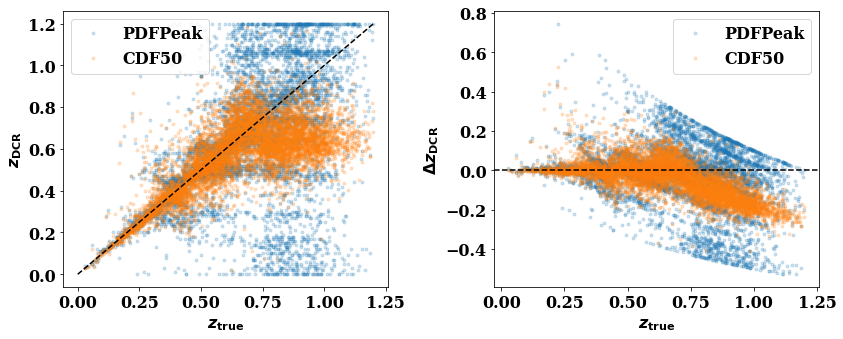

In [83]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
plt.plot(z_true_DCR, z_est_DCR_PDFPeak, '.', alpha = 0.2, label = 'PDFPeak')

plt.plot(z_true_DCR, z_est_DCR_CDF50, '.', alpha = 0.2, label = 'CDF50')

plt.plot(np.arange(0.00, 1.21, 0.01), np.arange(0.00, 1.21, 0.01), '--', color = 'k')
plt.xlabel(r'$z_{\rm{true}}$')
plt.ylabel(r'$z_{\rm{DCR}}$')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(z_true_DCR, (z_est_DCR_PDFPeak - z_true_DCR)/(1 + z_true_DCR), '.', alpha = 0.2, label = 'PDFPeak')
plt.plot(z_true_DCR, (z_est_DCR_CDF50 - z_true_DCR)/(1 + z_true_DCR), '.', alpha = 0.2, label = 'CDF50')
plt.axhline(y = 0, ls = '--', color = 'k')

plt.xlabel(r'$z_{\rm{true}}$')
plt.ylabel(r'$\Delta z_{\rm{DCR}}$')

plt.tight_layout()

plt.legend()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/Plots/Checks/sigma_MAD_clarification.png', dpi = 100, facecolor = 'white')

In [84]:
type_strs_with_lcfit = ['no_prior', 'host_prior', 'astro-z_prior', 'host_astro-z_prior']
for t in range(len(type_strs_with_lcfit)):
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_LCFIT+z_binned_FITPROB_eta0.10.txt' %type_strs_with_lcfit[t], residuals_exp_and_outliers_and_MAD(z_pred_types_cut_FITPROB[t], z_true[lcfit_types_cut_FITPROB[t]], np.linspace(0, 1.2, num = 13)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_LCFIT+z_all_z_FITPROB_eta0.10.txt' %type_strs_with_lcfit[t], residuals_exp_and_outliers_and_MAD(z_pred_types_cut_FITPROB[t], z_true[lcfit_types_cut_FITPROB[t]], np.linspace(0, 1.2, num = 2)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_LCFIT+z_high_low_z_FITPROB_eta0.10.txt' %type_strs_with_lcfit[t], residuals_exp_and_outliers_and_MAD(z_pred_types_cut_FITPROB[t], z_true[lcfit_types_cut_FITPROB[t]], np.linspace(0, 1.2, num = 3)))


In [85]:
type_strs_with_lcfit_compatible = ['host_astro-z_prior_compatible']
for t in range(len(type_strs_with_lcfit_compatible)):
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_LCFIT+z_binned_FITPROB_eta0.10.txt' %type_strs_with_lcfit_compatible[t], residuals_exp_and_outliers_and_MAD(z_pred_all_combined_cut_with_eta_considered_for_incompatible_priors_FITPROB, z_true[lcfit_types_cut_FITPROB[3]], np.linspace(0, 1.2, num = 13)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_LCFIT+z_all_z_FITPROB_eta0.10.txt' %type_strs_with_lcfit_compatible[t], residuals_exp_and_outliers_and_MAD(z_pred_all_combined_cut_with_eta_considered_for_incompatible_priors_FITPROB, z_true[lcfit_types_cut_FITPROB[3]], np.linspace(0, 1.2, num = 2)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_LCFIT+z_high_low_z_FITPROB_eta0.10.txt' %type_strs_with_lcfit_compatible[t], residuals_exp_and_outliers_and_MAD(z_pred_all_combined_cut_with_eta_considered_for_incompatible_priors_FITPROB, z_true[lcfit_types_cut_FITPROB[3]], np.linspace(0, 1.2, num = 3)))


In [86]:
type_strs_with_lcfit_compatible = ['no_prior']
for t in range(len(type_strs_with_lcfit_compatible)):
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_LCFIT+z_binned_FITPROB_cosmology_prior_eta0.10.txt' %type_strs_with_lcfit_compatible[t], residuals_exp_and_outliers_and_MAD(z_pred_types_cut_FITPROB[4], z_true[lcfit_types_cut_FITPROB[4]], np.linspace(0, 1.2, num = 13)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_LCFIT+z_all_z_FITPROB_cosmology_prior_eta0.10.txt' %type_strs_with_lcfit_compatible[t], residuals_exp_and_outliers_and_MAD(z_pred_types_cut_FITPROB[4], z_true[lcfit_types_cut_FITPROB[4]], np.linspace(0, 1.2, num = 2)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/realistic/z_metrics_type_%s_LCFIT+z_high_low_z_FITPROB_cosmology_prior_eta0.10.txt' %type_strs_with_lcfit_compatible[t], residuals_exp_and_outliers_and_MAD(z_pred_types_cut_FITPROB[4], z_true[lcfit_types_cut_FITPROB[4]], np.linspace(0, 1.2, num = 3)))


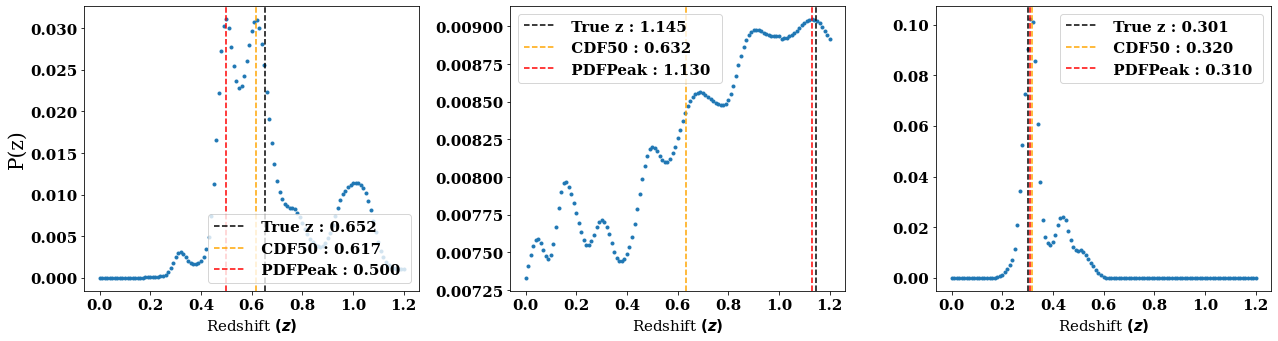

In [87]:
#Realistic sims only



font = {'family' : 'serif',
        'weight' : 'bold',
        'style'  : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

plt.subplots(1, 3, figsize = [18, 5])

#plt.supylabel('Relative Frequency')
nbins = 25

#type_strs = ['CDF50', 'LSST']

CID_ind = [10, 22, 58]

for t in range(len(CID_ind)):
    plt.subplot(1, 3, t+1)
    normed_post = z_preds_wrt_zY_combined_with_lcfit_tobs[2][CID_ind[t]]/np.sum(z_preds_wrt_zY_combined_with_lcfit_tobs[2][CID_ind[t]])
    plt.plot(z_range, normed_post, '.')
    plt.axvline(x = z_true[CID_ind[t]], ls = '--', color = 'black', label = r' True z : %.3f ' %z_true[CID_ind[t]])#, z_preds[0][CID_ind[t]][0], z_preds[1][CID_ind[t]][0]))
    plt.axvline(x = z_preds_wrt_zY_combined_with_lcfit_tobs[0][CID_ind[t]][0], ls = '--', color = 'orange', label = ' CDF50 : %.3f ' %z_preds_wrt_zY_combined_with_lcfit_tobs[0][CID_ind[t]][0])
    plt.axvline(x = z_preds_wrt_zY_combined_with_lcfit_tobs[1][CID_ind[t]][0], ls = '--', color = 'red', label = ' PDFPeak : %.3f ' %z_preds_wrt_zY_combined_with_lcfit_tobs[1][CID_ind[t]][0])
    
    #plt.axvline(x = \n CDF 50 : %.3f \n Peaks   : %.3f)
    plt.xlabel(r'Redshift $(z)$')
    #plt.xticks(np.linspace(1.0, 2.0, num = 6))
    if t == 0:
        plt.ylabel('P(z)', fontsize = 20)
    #if d != 3:
    #    plt.xticks([])
    #plt.text(0.5, np.min(normed_post), )
    plt.xticks(np.linspace(0, 1.2, num = 7))
    if t == 0:
        plt.legend(loc = 'lower right')
    else:
        plt.legend(loc = 'best')

plt.subplots_adjust(hspace = 0.) 
plt.tight_layout()
plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/for_IR_Apr2024/posterior_examples_SALT3.png', facecolor = 'white', transparent = False, dpi = 100)

